In [33]:
# Imports
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path


In [34]:
#Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../01-ML_Trading_Data/ohlcv.csv"),
    index_col="date",
    infer_datetime_format=True,
    parse_dates=True
)

# Display sample data
trading_df.head()


,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


In [35]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Display sample data
trading_df.head()

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522,NaN
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874,0.000000


In [36]:
# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:45:00,17.11,17.44,17.11,17.40,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.28,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.20,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.20,46874,0.000000
2018-10-19 10:45:00,17.20,17.20,17.10,17.12,11266,-0.004651


,open,high,low,close,volume,actual_returns
date,,,,,,
2020-09-04 14:45:00,6.225,6.26,6.220,6.250,55512,0.003210
2020-09-04 15:00:00,6.255,6.27,6.245,6.250,65810,0.000000
2020-09-04 15:15:00,6.250,6.29,6.250,6.275,202630,0.004000
2020-09-04 15:30:00,6.270,6.28,6.250,6.255,130140,-0.003187
2020-09-04 15:45:00,6.250,6.28,6.250,6.250,190278,-0.000799


In [37]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
trading_df['sma_fast'] = trading_df['close'].rolling(window=short_window).mean()


In [38]:
# Define a window size of 100
long_window = 100

# Create an SMA that uses long_window, and assign it to a new column named “sma_slow”
trading_df['sma_slow'] = trading_df['close'].rolling(window=long_window).mean()

In [39]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [40]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = trading_df[['sma_fast', 'sma_slow']].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2018-10-24 15:15:00,15.65250,16.3403
2018-10-24 15:30:00,15.61875,16.3216
2018-10-24 15:45:00,15.55375,16.3029
2018-10-25 09:30:00,15.47625,16.2844
2018-10-25 09:45:00,15.40250,16.2656


,sma_fast,sma_slow
date,,
2020-09-04 14:45:00,6.22625,6.27210
2020-09-04 15:00:00,6.22875,6.27030
2020-09-04 15:15:00,6.23875,6.26985
2020-09-04 15:30:00,6.25125,6.26910
2020-09-04 15:45:00,6.25750,6.26855


In [41]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df['signal'] = 0.0

In [42]:
# Create the signal to buy
trading_df.loc[(trading_df['actual_returns'] >= 0), 'signal'] = 1

# Create the signal to sell
trading_df.loc[(trading_df['actual_returns'] < 0), 'signal'] = -1

In [43]:
# Copy the new "signal" column to a new Series called `y`.
y = trading_df['signal'].copy()

In [44]:
from pandas.tseries.offsets import DateOffset

In [45]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2018-10-24 15:15:00
2019-01-24 15:15:00


In [46]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
date,,
2018-10-24 15:15:00,15.65250,16.3403
2018-10-24 15:30:00,15.61875,16.3216
2018-10-24 15:45:00,15.55375,16.3029
2018-10-25 09:30:00,15.47625,16.2844
2018-10-25 09:45:00,15.40250,16.2656


In [47]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
date,,
2019-01-24 15:15:00,14.1600,14.29466
2019-01-24 15:30:00,14.1600,14.29036
2019-01-24 15:45:00,14.1575,14.28666
2019-01-25 09:30:00,14.1525,14.28161
2019-01-25 09:45:00,14.1750,14.27791


In [48]:
# Import the required module
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [49]:
# Import the SVM model
from sklearn import svm

In [50]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [51]:
# Import the required module
from sklearn.metrics import classification_report

# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

print(training_report)


              precision    recall  f1-score   support

        -1.0       0.53      0.11      0.19       740
         1.0       0.52      0.90      0.66       777

    accuracy                           0.52      1517
   macro avg       0.52      0.51      0.42      1517
weighted avg       0.52      0.52      0.43      1517



In [52]:
# the results of the classification report are not very good. 
# The model is not very accurate. 
# We will need to tune the model to improve the results.

# difference between recall and accuracy explained :
# Accuracy tells you how many times the ML model was correct overall. 
# Precision is how good the model is at predicting a specific category. 
# Recall tells you how many times the model was able to detect a specific category.

# The precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.
# a low precision score is bad. What is a high precision score? 0.8-1. What is a low precision score? 0-0.2

# The recall is defined as the number of true positives divided by the number of true positives plus the number of false negatives.
# a low recall score is bad. What is a high recall score? 0.8-1. What is a low recall score? 0-0.2

# The f1-score is the harmonic mean of the precision and recall.
# a normal f1-score is what range? 0-1. What is a high f1-score? 0.8-1. What is a low f1-score? 0-0.2

# The support is the number of occurrences of each class in y_true.
# The accuracy is the number of correct predictions divided by the total number of predictions.

# The macro avg is the unweighted mean of the precision, recall, and f1-score.
# a good macro avg is what range? 0-1. What is a high macro avg? 0.8-1. What is a low macro avg? 0-0.2

# The weighted avg is the weighted mean of the precision, recall, and f1-score.
# The weighted avg is the average of the f1-score for each class, weighted by the number of true instances in each class.
# a good weighted avg is what range? 0-1. What is a high weighted avg? 0.8-1. What is a low weighted avg? 0-0.2

# The precision is 0.53 for the training data (-1.0) and 0.52 for the testing data (1.0).
# The recall is 0.11 for the training data (-1.0) and 0.9 for the testing data (1.0).


In [53]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [55]:
# Evaluate the model's ability to predict the trading signal for the testing data use zero_division
 
svm_testing_report = classification_report(y_test, testing_signal_predictions)

print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      4894
         1.0       0.53      1.00      0.69      5558

    accuracy                           0.53     10452
   macro avg       0.27      0.50      0.35     10452
weighted avg       0.28      0.53      0.37     10452



/Users/michaeldionne/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaeldionne/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaeldionne/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [58]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]


# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2019-01-24 15:15:00,1.0,0.001412,0.001412
2019-01-24 15:30:00,1.0,-0.001410,-0.001410
2019-01-24 15:45:00,1.0,-0.003531,-0.003531
2019-01-25 09:30:00,1.0,0.009922,0.009922
2019-01-25 09:45:00,1.0,0.002105,0.002105


<AxesSubplot:xlabel='date'>

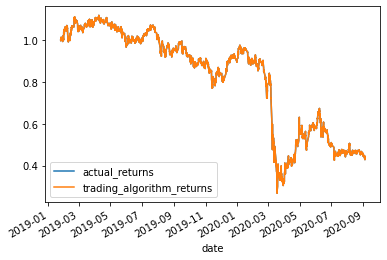

In [59]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()
 